In [136]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-reviews/amazon_review.csv


In [137]:
df = pd.read_csv('/kaggle/input/amazon-reviews/amazon_review.csv')

In [138]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


In [140]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

In [141]:
from datetime import date
today = date.today()

In [142]:
max(df['reviewTime'])

Timestamp('2014-12-07 00:00:00')

In [143]:
min(df['reviewTime'])

Timestamp('2012-01-09 00:00:00')

In [144]:
df['reviewTime'].dt.to_period('M').value_counts()

reviewTime
2013-12    306
2014-01    263
2014-03    242
2013-07    234
2013-08    232
2013-06    231
2013-02    225
2013-11    223
2014-02    218
2013-09    216
2013-10    211
2013-05    207
2012-12    203
2013-01    201
2013-03    201
2014-06    197
2013-04    191
2014-05    185
2014-04    184
2014-07    113
2012-11     87
2014-10     71
2014-08     71
2014-09     70
2014-12     66
2014-11     56
2012-10     45
2012-09     41
2012-08     30
2012-05     17
2012-02     17
2012-06     16
2012-07     16
2012-01     11
2012-04     11
2012-03      7
Freq: M, Name: count, dtype: int64

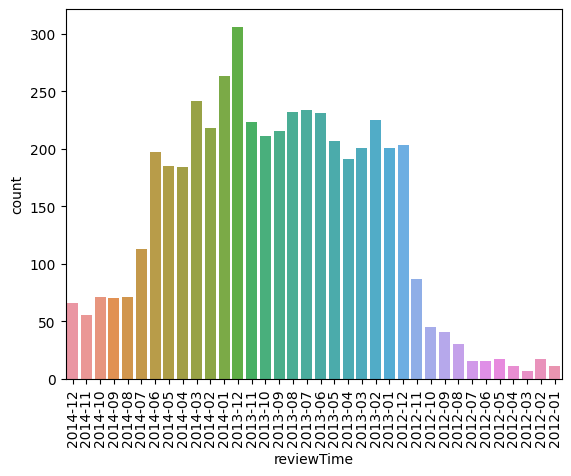

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data = df, x = df.sort_values('reviewTime', ascending = False)['reviewTime'].dt.to_period('M'))
plt.xticks(rotation=90)
plt.show()

In [146]:
df['overall'].mean()

4.587589013224822

In [147]:
df['timeWeight'] = df['day_diff'] * (-1)

In [148]:
from sklearn.preprocessing import MinMaxScaler
df['timeWeightScale'] = MinMaxScaler(feature_range = (1, 5)).fit_transform(df[['day_diff']] * (-1))

In [149]:
df['timeScore'] = df['timeWeightScale'] * 0.3 + df['overall'] * 0.7

In [150]:
df['timeScore'].mean()

4.218706055626746

In [151]:
df['overall'].mean()

4.587589013224822

### Top 20

In [152]:
def wilson_lower_bound(up, down, confidence=0.95):
    """
    Wilson Lower Bound Score hesapla

    - Bernoulli parametresi p için hesaplanacak güven aralığının alt sınırı WLB skoru olarak kabul edilir.
    - Hesaplanacak skor ürün sıralaması için kullanılır.
    - Not:
    Eğer skorlar 1-5 arasıdaysa 1-3 negatif, 4-5 pozitif olarak işaretlenir ve bernoulli'ye uygun hale getirilebilir.
    Bu beraberinde bazı problemleri de getirir. Bu sebeple bayesian average rating yapmak gerekir.

    Parameters
    ----------
    up: int
        up count
    down: int
        down count
    confidence: float
        confidence

    Returns
    -------
    wilson score: float

    """
    n = up + down
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * up / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)


In [153]:
df['helpful_no'] = df['total_vote'] - df['helpful_yes']

In [154]:
import scipy.stats as st
df['wilsonLowerBound'] = df.apply(lambda x: wilson_lower_bound(x['helpful_yes'], x['helpful_no']), axis=1)

In [156]:
df.sort_values(['wilsonLowerBound'], ascending = False).head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,timeWeight,timeWeightScale,timeScore,helpful_no,wilsonLowerBound
2031,A12B7ZMXFI6IXY,B007WTAJTO,"Hyoun Kim ""Faluzure""","[1952, 2020]",[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,5.0,UPDATED - Great w/ Galaxy S4 & Galaxy Tab 4 10...,1367366400,2013-01-05,702,1952,2020,-702,2.362183,4.208655,68,0.957544
3449,AOEAD7DPLZE53,B007WTAJTO,NLee the Engineer,"[1428, 1505]",I have tested dozens of SDHC and micro-SDHC ca...,5.0,Top of the class among all (budget-priced) mic...,1348617600,2012-09-26,803,1428,1505,-803,1.982126,4.094638,77,0.936519
4212,AVBMZZAFEKO58,B007WTAJTO,SkincareCEO,"[1568, 1694]",NOTE: please read the last update (scroll to ...,1.0,1 Star reviews - Micro SDXC card unmounts itse...,1375660800,2013-05-08,579,1568,1694,-579,2.825024,1.547507,126,0.912139
317,A1ZQAQFYSXL5MQ,B007WTAJTO,"Amazon Customer ""Kelly""","[422, 495]","If your card gets hot enough to be painful, it...",1.0,"Warning, read this!",1346544000,2012-02-09,1033,422,495,-1033,1.116651,1.034995,73,0.818577
4672,A2DKQQIZ793AV5,B007WTAJTO,Twister,"[45, 49]",Sandisk announcement of the first 128GB micro ...,5.0,Super high capacity!!! Excellent price (on Am...,1394150400,2014-07-03,158,45,49,-158,4.409219,4.822766,4,0.808109
1835,A1J6VSUM80UAF8,B007WTAJTO,goconfigure,"[60, 68]",Bought from BestBuy online the day it was anno...,5.0,I own it,1393545600,2014-02-28,283,60,68,-283,3.938852,4.681656,8,0.784651
3981,A1K91XXQ6ZEBQR,B007WTAJTO,"R. Sutton, Jr. ""RWSynergy""","[112, 139]",The last few days I have been diligently shopp...,5.0,"Resolving confusion between ""Mobile Ultra"" and...",1350864000,2012-10-22,777,112,139,-777,2.079962,4.123989,27,0.732136
3807,AFGRMORWY2QNX,B007WTAJTO,R. Heisler,"[22, 25]",I bought this card to replace a lost 16 gig in...,3.0,"Good buy for the money but wait, I had an issue!",1361923200,2013-02-27,649,22,25,-649,2.561618,2.868485,3,0.700442
4306,AOHXKM5URSKAB,B007WTAJTO,Stellar Eller,"[51, 65]","While I got this card as a ""deal of the day"" o...",5.0,Awesome Card!,1339200000,2012-09-06,823,51,65,-823,1.906867,4.072060,14,0.670334
4596,A1WTQUOQ4WG9AI,B007WTAJTO,"Tom Henriksen ""Doggy Diner""","[82, 109]",Hi:I ordered two card and they arrived the nex...,1.0,Designed incompatibility/Don't support SanDisk,1348272000,2012-09-22,807,82,109,-807,1.967074,1.290122,27,0.663595
